# TensorFlow Tutorials
# ML Basics 02 - Basic Regression

## Environment Setup

In [6]:
# Python 2.7-proofing the workspace
from __future__ import absolute_import, division, print_function, unicode_literals 

In [7]:
# Not sure what this library will be used for 
import pathlib

In [17]:
# Plotting libaries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [13]:
try:
    # TensorFlow 2 and above may not be installed
    %tensorfow_version 2.x
except Exception:
    pass

# Confirming version of tensorflow
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

1.13.1


## Loading Data
Using the UCI Machine Learning Repository's Auto MPG dataset to build a model that predicts fuel efficiency for vehicles using features such as cylinders, displacement, horsepower, weight, etc.

In [15]:
# Remember path to the dataset after downloading it from specified URL
dataset_path = keras.utils.get_file("auto-mpg-.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

# Echo the path
dataset_path

32768/30286 [================================] - 0s 10us/step


'C:\\Users\\saads\\.keras\\datasets\\auto-mpg-.data'

In [19]:
# Need to define the column names for this dataset
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 
               'Acceleration', 'Model Year', 'Origin']

# Read the dataset from the filepath with the column names specified
# If there are any missing values, replace them with '?'
# Even though this is a comma-separated value file, the separator for this dataset is actually a space
# All this data is read into a pandas dataframe - a spreadsheet-esque structure for efficient data analysis
raw_dataset = pd.read_csv(dataset_path, names=column_names, 
           na_values='?', comment='\t', 
           sep=' ', skipinitialspace=True); # Semicolon necessary to suppress OP

# Create a local copy of the dataset to prevent mutation
dataset = raw_dataset.copy()

# Examine the last 5 entries in the dataset
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Data Preprocessing

In [20]:
# The dataset contains a few unknown values
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [21]:
# Dropping rows with missing data for simplicity
dataset = dataset.dropna()

In [22]:
# Origin column is categorical, not numeric. 
# Use one-hot encoding to convert it to binary-encoded categorical data
origin = dataset.pop('Origin')

# Create new columns for each category in origin 
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0

# Examine the dataset to confirm the new columns have been added
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [23]:
# Train test split

# Use the `sample` function to obtain a random sample consisting of 80% of all samples
# Random state ensures that the same pseudorandom numbers are generated for 
# getting the training data as the tutorial notebook - so tutorial and our NB
# will have the same samples
train_dataset = dataset.sample(frac=0.8, random_state=0)


# Any samples present in the randomly generated training set must not be in the test set
test_dataset = dataset.drop(train_dataset.index)

Exploring trends and relationships between pairs of features in the dataset using seaborn's `pairplot` command.

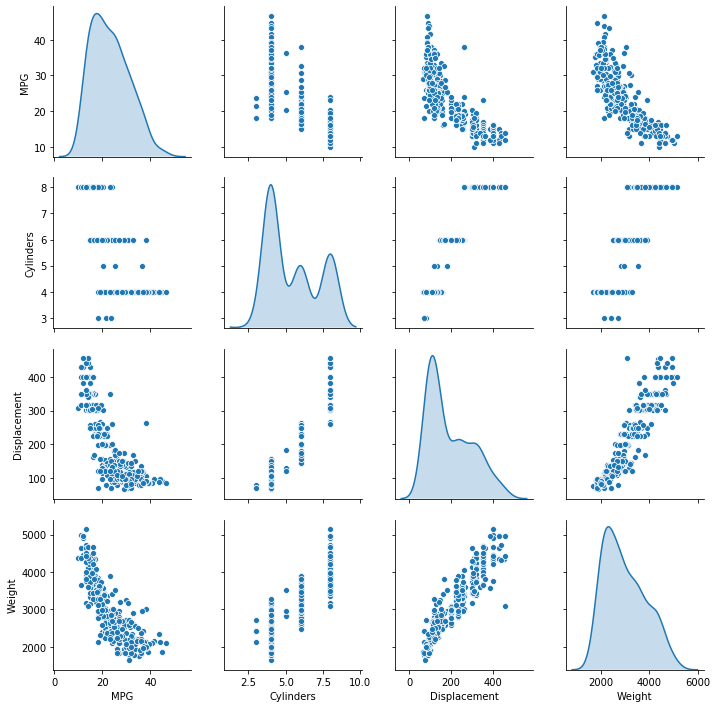

In [24]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], 
            diag_kind='kde')

In [27]:
# Overall statistics of numeric columns - mean, std, min, max, quartiles
train_stats = train_dataset.describe()

# Removing the `MPG` column from the statistics
train_stats.pop('MPG')

# Transposing so that the statistics are displayed as columns rather than rows
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


Splitting the features from labels. Features are what we will be using to make predictions. Labels (or targets) are the actual values for a quantity we will be predicting for each training example.

In this case we want to predict the `MPG` of each vehicle, so we will remove this column from the train and test datasets, thereby changing them into np arrays of features only.

In [28]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

Normalizing the training data - transforming different features (with different scales and ranges) onto the same, uniform range. Makes training easier, and makes the model more likely to converge. Also decreases likelihood that the model will be skewed by features which take on larger values. Also makes the resulting model independent of the units used in the input.

Use the training data mean and standard deviation to normalize Both the training data and test data. Can't use the test data because implicitly we always assume that we just don't have access to it, so the test data can't affect the model even implicitly.

In [30]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## Building a Model

In [34]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

In [36]:
# Get a newly built sequential model configured for regression
model = build_model()

In [37]:
# A simple description of the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


## Training the Model

In [38]:
# Model performance prior to training
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.26331037],
       [ 0.28499028],
       [-0.34914955],
       [ 0.5334423 ],
       [ 0.00093471],
       [ 0.1393937 ],
       [-0.01611254],
       [-0.47907543],
       [ 0.08971667],
       [-0.38121873]], dtype=float32)

The model seems to be working. It has predicted MPG values for each of the 10 samples that were passed to it as inputs.

However, the model hasn't been trained yet. It's predictions are based on randomly initialized weights.

In [40]:
# Display the training process by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs):
        if epochs % 100 == 0:
            print('')
        print('.', end='')

# Epochs = number of complete passes over the entire training set
EPOCHS = 1000

# The training process returns a history object that contains logs for the entire training process
# Validation split = 0.2 means 20% of the training data will also be used to 
# evaluate the model's performance **during performance**. The callback class
# we created earlier allows us to specify what will happen every time an epoch is completed
history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0, 
    callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

## Visualizing Model Training Progress

In [41]:
# Cast the history property from the history object and store as dataframe
hist = pd.DataFrame(history.history)

# Create a new column called 'epoch' using the epoch property on the history object
hist['epoch'] = history.epoch

# Examine the last 5 values in this dataframe
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.520334,0.982782,2.520334,9.343721,2.441189,9.343721,995
996,2.642481,1.015383,2.642480,9.341081,2.444141,9.341081,996
997,2.719902,1.021355,2.719902,9.285990,2.443765,9.285991,997
998,2.550472,0.997008,2.550472,9.247108,2.418653,9.247108,998
999,2.540849,1.005013,2.540849,9.289357,2.431949,9.289357,999


In [51]:
# Function to plot the history data
def plot_history(history):
    # Same as above
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    # Creating a figure for Mean Absolute Error
    plt.figure()
    # Training MAE
    plt.xlabel('Epoch'); plt.ylabel('Mean Abs Error [MPG]');
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    # Test MAE
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label='Val Error')
    
    # Creating a figure for Mean Square Error
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'], label='Val Error')
    
    # Finishing touches
    plt.ylim([0, 20])
    plt.legend()
    
    plt.show()

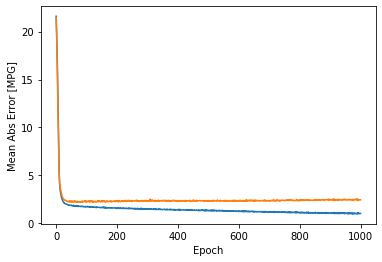

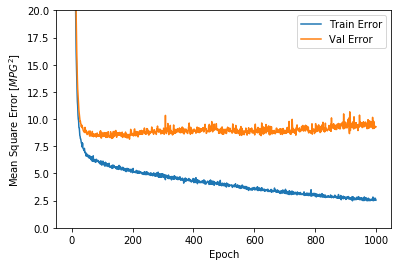

In [52]:
plot_history(history)

The validation mean absolute and mean squared errors are both higher than their training set counterparts. This is evidence of overfitting.


....................................................

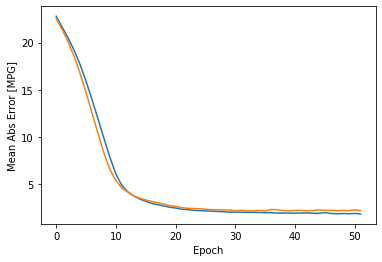

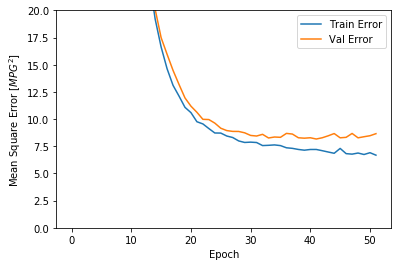

In [54]:
# Modifying the model to stop training as soon as it detects overfitting
# i.e. as soon as the validation error stops improving 
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model again and store its training history
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, 
                   validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

# Plot the history after early stopping implemented
plot_history(history)

On the validation set, the average error isu sually +/-2 MPG. This is good enough for a first model. We have successfully minimised overfitting. Can tweak the hyperparameters of the model to try and improve prediction performance.

## Predictions on Test Set

In [59]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Test set mean absolute error: {:5.2f} MPG".format(mae))

Test set mean absolute error:  2.07 MPG


The mean absolute error on the test set is approximately the same as that on the validation set, which indicates that we have indeed been able to counter overfitting.

### Visualizing Predictions

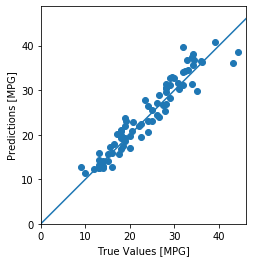

In [69]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

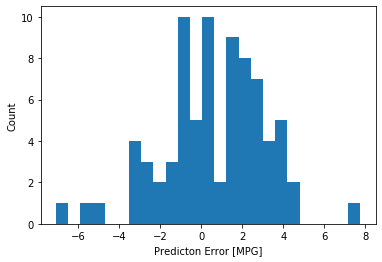

In [70]:
# Visualizing errors
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Predicton Error [MPG]')
_ = plt.ylabel('Count')

Errors is not exactly Gaussain, which implies it isn't exactly random and can be explained by the NN not learning the best possible mapping from features to MPG. However, given the training set size (80% of 308 samples), this is still good enough. 